In [565]:
# Import the necessary Python libraries
import pandas as pd        # For data analysis
import jieba               # For Chinese text tokenization. a more powerful tokenization tool dedicated to chinese text than NLTK or SpaCy.
from collections import Counter, defaultdict  # For statistics and dictionary operations
from wordcloud import WordCloud  # For wordcloud generation
import matplotlib.pyplot as plt  # For visualiztion
import seaborn as sns     # For visualizaion
from snownlp import SnowNLP  # For sentiment orientation analysis in chinese text.


In [567]:
# Read the comments from the video "Time_to_say_Goodbye" in 7.11.2020. https://www.bilibili.com/video/BV1cy4y1z7cQ/?spm_id_from=333.1391.0.0&vd_source=42408ad57c7f3511be70703e4e0a79f4
df = pd.read_csv("/Users/cuiziyi/Desktop/Project_<AF43460>/Time_to_say_Goodbye_07.11.2020.csv", encoding="utf-8")  # 替换为你的 CSV 文件路径

# check the data structure
print(df.head())

# Remove null values
df = df.dropna(subset=["comments"])  #Remove empty comments
df["comments"] = df["comments"].str.strip()  # Remove spaces before and after

# Data preview
print(f"The data has {len(df)} comments.")


                                  comments
0  特朗普说自己的国家是控制疫情最好的国家。 刚开始我觉得好笑，顿了一下，我泪目了
1                     人家讲真话的时候你们还笑话他[doge]
2                       建国说的可是“自己的”国家啊[大哭]
3                       哎，远方的游子啊[大哭][doge]
4                              洋装虽然穿在身[滑稽]
The data has 77 comments.


In [569]:
# This step is to  define the pre-processing criteria for the raw comments, such as the removal of stopwords, meaningless content, non-chinese, token of non-chinese,english and numbers.
# and tokenization of the data. This step aims to better recognize meaningful Chinese characters, which helps to enhance the accuracy of the later sentiment analysis.


import re 
# Import The Regular Expression module, or re module. This module provides tools to support regular expression manipulation, which can be used to handle string matching, finding, replacing, splitting, and other tasks.
def load_stopwords(filepath):
    with open(filepath, "r", encoding="utf-8") as f:
        stopwords = set(f.read().splitlines())  #the splitline function ensures the line breaks (e.g. \n, \r\n) from different operating systems can be handled safely, because of the characteristics of the stop word list arranged in rows.
    return stopwords

# the filepath of the target stopwords.  The chinese stopwords file is accessed in an external file from Github. https://github.com/elephantnose/characters/blob/master/stop_words.
stopwords = load_stopwords("/Users/cuiziyi/Desktop/Project_<AF43460>/stop_words.txt")

# define the parameter of data pre-processing, using Regex, external stopwords list, and jieba tokenization.

def clean_text(text, stopwords):
    # 1. Remove content like [doge]
    text = re.sub(r"\[.*?\]", "", text)
    
    # 2. Remove non-Chinese, English, and numeric characters
    text = re.sub(r"[^\u4e00-\u9fa5a-zA-Z0-9\s]", "", text)
    
    # 3. tokenization
    words = jieba.lcut(text)
    
    # 4. remove stopwords
    words = [word for word in words if word not in stopwords]
    
    # 5. Return to cleaned text
    return " ".join(words)

# load raw material
df = pd.read_csv("/Users/cuiziyi/Desktop/Project_<AF43460>/Time_to_say_Goodbye_07.11.2020.csv", encoding="utf-8")

# apply the cleaning parameter. 
#lambda function is a short, nameless function provided by Python, mainly used in scenarios where simple functions need to be temporarily defined.
#The .apply() function is to collect all processed results into a new Series, adding value to df[“cleaned_comments”].
df["cleaned_comments"] = df["comments"].apply(lambda x: clean_text(x, stopwords))

# check the cleaning result.
print(df[["comments", "cleaned_comments"]].head())


                                  comments                cleaned_comments
0  特朗普说自己的国家是控制疫情最好的国家。 刚开始我觉得好笑，顿了一下，我泪目了  特朗普 说 国家 控制 疫情 国家   刚 好笑 顿 我泪目
1                     人家讲真话的时候你们还笑话他[doge]                         讲 真话 笑话
2                       建国说的可是“自己的”国家啊[大哭]                         建国 说 国家
3                       哎，远方的游子啊[大哭][doge]                           远方 游子
4                              洋装虽然穿在身[滑稽]                          洋装 穿 身


In [571]:
# define the name and his nicknames of Donald Trump for locating and extracting the most relevant comments about the construction of Trump's image
aliases = ["特朗普", "懂皇", "建国", "川宝", "川建国","懂王","川普"]

# The prompt of ChatGPT: "help me to generate the code for filtering the comments without Trump's aliases."
# prompt: "explain the code of "any(alias in text for alias in aliases)" for me."
#Checks if this text contains any of the aliases in the alias list.
#Returns True if it contains any of the aliases; otherwise returns False.

def filter_comments(text, aliases):
    return any(alias in text for alias in aliases)

df["mention_trump"] = df["cleaned_comments"].apply(lambda x: filter_comments(x, aliases))
filtered_comments = df[df["mention_trump"]] 

# after filtering, check the quantity of remaining comments.
print(f"The number of comments mentioning Trump and his aliases：{len(filtered_comments)}")


The number of comments mentioning Trump and his aliases：36


In [573]:
# the most common sentiment analysis database dedicated to chinese text.
from snownlp import SnowNLP

# define the parameter of sentiment analysis
def sentiment_analysis(text):
    s = SnowNLP(text)
    return s.sentiments  # Returns the sentiment score (between 0~1)

# Define sentiment label function 
def sentiment_label(score):
    if score > 0.7:
        return "Positive"
    elif score < 0.3:
        return "Negative"
    else:
        return "Neural"

# Calculating sentiment scores among comments mentioning Trump
filtered_comments["sentiment_score"] = filtered_comments["cleaned_comments"].apply(sentiment_analysis)

# Divide sentiment labels based on scores
filtered_comments["sentiment_label"] = filtered_comments["sentiment_score"].apply(sentiment_label)

# use .value_counts to count the occurrences of each unique value in sentiment label.
sentiment_counts = filtered_comments["sentiment_label"].value_counts()
print("sentiment orientation：")
print(sentiment_counts)


sentiment orientation：
sentiment_label
Positive    24
Neural       9
Negative     3
Name: count, dtype: int64


/var/folders/3t/p28d_6fx0cjgsb7lzdn2q4d40000gn/T/ipykernel_9355/1778891659.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_comments["sentiment_score"] = filtered_comments["cleaned_comments"].apply(sentiment_analysis)
/var/folders/3t/p28d_6fx0cjgsb7lzdn2q4d40000gn/T/ipykernel_9355/1778891659.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_comments["sentiment_label"] = filtered_comments["sentiment_score"].apply(sentiment_label)


In [575]:
#check the actual comments with sentiment score.
filtered_comments["sentiment_score"] = filtered_comments["cleaned_comments"].apply(sentiment_analysis)
print(filtered_comments[["cleaned_comments", "sentiment_score"]])
#the results show the limitation of SnowNLP, as in chinese context, the sentiment orientation of comments are not all positive.

                                     cleaned_comments  sentiment_score
0                      特朗普 说 国家 控制 疫情 国家   刚 好笑 顿 我泪目         0.681808
2                                             建国 说 国家         0.499825
8                            这点儿 失败 不算什么 建国 同志 年 卷土重来         0.184680
13                                         建国 打退堂鼓 这是         0.282022
16                                         别尬 黑 我川宝 翻         0.483630
17                                          奶 一口 川 建国         0.984284
18                                      懂王 赢 大选 总统 关系         0.665880
23  沈逸 老师 视频 里 说 被川 普查 票有 川普 州 翻 川宝 加油 漂亮 国 搞乱 宪 政...         0.999988
24                        回复   余生 Charles   其他人 没川普 搞         0.668460
25  回复   做人 莱肯   特朗普 搞 是因为 穷途末路 别无选择   新闻 无视 言论 推 ...         0.431247
26                    拖延 11 月 选举人 票 真人 投 大法官 建国 同志 任命         0.135039
27  回复   余生 Charles   共和党 敢 川普 划清界限 川普 敢 带 6900 万 ...         0.999915
28  共和党 全力支持 特朗普 对抗 拜登 民主党 情况 依旧 翻盘 可惜 共和党 老 早就 和川...         1.000000
29  回复

/var/folders/3t/p28d_6fx0cjgsb7lzdn2q4d40000gn/T/ipykernel_9355/2710790015.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_comments["sentiment_score"] = filtered_comments["cleaned_comments"].apply(sentiment_analysis)


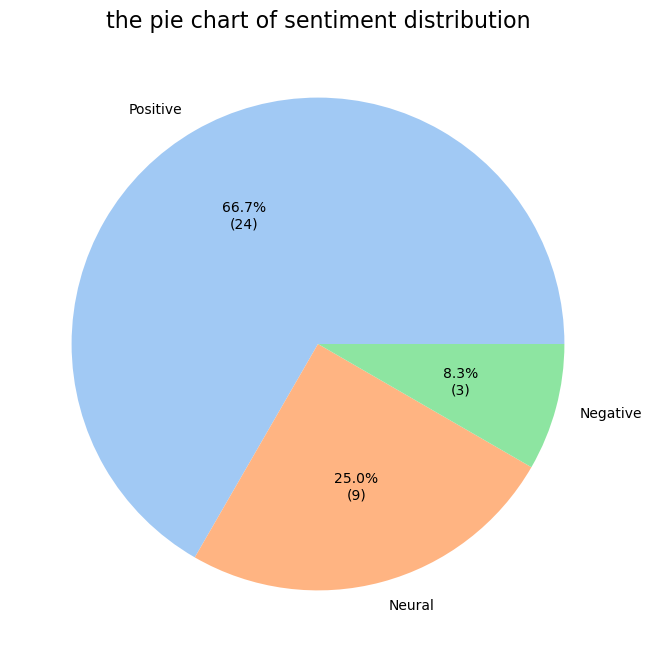

<Figure size 640x480 with 0 Axes>

In [577]:
# use seaborn and matplotlib to generate the pie chart of sentiment distribution.
# prompt:"help me to set an appropriate parameter for the pie chart of sentiment distribution"

def autopct_format(pct, all_values):
    total = sum(all_values)  # the total number of comments
    absolute = int(round(pct * total / 100.0))  # Calculate the absolute number
    return f"{pct:.1f}%\n({absolute})"  # Show percentage and absolute numbers

plt.figure(figsize=(8, 8)) #Set the size of the canvas to 8 inches wide and 8 inches high to produce a square canvas.
plt.pie(
    sentiment_counts.values, #.values extracts the values in the series of sentiment_counts, i.e. the number of sentiment labels (Positive, Neutral, Negative).
    labels=sentiment_counts.index, #.index Extract the index of the Series, i.e., the sentiment labels (Positive, Neutral, Negative)
    autopct=lambda pct: autopct_format(pct, sentiment_counts.values), #show the percentage of each sector in 1-digit decimal format.” %1.1f%%” indicates that one decimal place is retained, e.g. ‘25.0%’.
    colors=sns.color_palette("pastel")[0:len(sentiment_counts)]#Use Seaborn's color_palette() to generate a set of colors."pastel" is a soft color scheme. [0:len(sentiment_counts)] dynamically selects colors based on the number of sentiment labels, ensuring that each sentiment label has a separate color.
)
plt.title("the pie chart of sentiment distribution", fontsize=16) #add the title of chart
plt.show()

#save the pie chart image in png format
plt.savefig("sentiment_piechart.png", dpi=300)

In [579]:
# Segmentation and counting of high-frequency words

all_tokens = []
for comment in filtered_comments["cleaned_comments"]:
    tokens = jieba.lcut(comment)
    all_tokens.extend(tokens)
#.extend function is to add each element of the other list separately to the target list.
# calculate the top-20 high-frequency words
token_counts = Counter(all_tokens)
print("high-frequency words：", token_counts.most_common(20))


high-frequency words： [(' ', 1069), ('川宝', 49), ('特朗普', 33), ('拜登', 21), ('川普', 16), ('美国', 15), ('安倍', 11), ('奥巴马', 11), ('总统', 10), ('说', 9), ('建国', 9), ('大选', 7), ('国家', 6), ('回复', 5), ('支持', 5), ('哈哈哈哈', 5), ('年', 4), ('川', 4), ('余生', 4), ('Charles', 4)]


In [581]:
# use set([]) to create an unordered set of non-repeating stopwords list.
stopwords = set(["", " ", "的", "是", "在", "和", "有", "说", "没", "那种","哈哈哈哈哈","哈哈哈"])  

# create a dictionary of filtered token counts.
filtered_token_counts = {word: count for word, count in token_counts.items() if word not in stopwords}
# "word: count for word, count in token_counts.items() if word not in stopwords" this code means that set variables of word and counts and then give them values from token_counts.
# In loop, check if the word is not in the stopwords set. If the word is not in the stopwords list, the word and its corresponding count are added to a new dictionary, filtered_token_counts.

In [583]:
# Redefining high-frequency words using word frequencies after removing the stopwords
# and show the top10 words.

high_freq_words = sorted(filtered_token_counts.items(), key=lambda x: x[1], reverse=True)[:10]
print("high-frequency list：", high_freq_words)
# the translated result of high-frequency list is [Trumpe,49; Donald Trump, 33; Biden,12; Abe,11; Obama,11; Jianguo in Chinese pinyin,9; President,8;selection,7;country,5]

high-frequency list： [('川宝', 49), ('特朗普', 33), ('拜登', 21), ('川普', 16), ('美国', 15), ('安倍', 11), ('奥巴马', 11), ('总统', 10), ('建国', 9), ('大选', 7)]


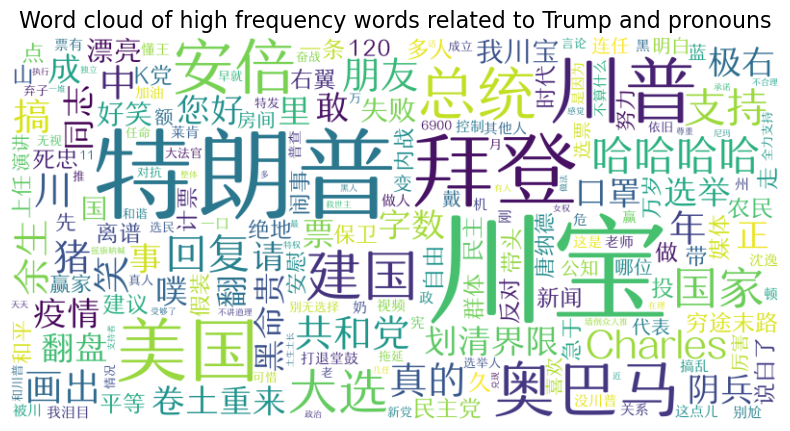

In [585]:
# create the wordcloud of all the high-frequency words related to Trump.

wordcloud = WordCloud(
    font_path="/Users/cuiziyi/Desktop/Project_<AF43460>/汉仪润圆45W.ttf", 
    background_color="white",       
    width=800,                      
    height=400                      
).generate_from_frequencies(filtered_token_counts) 

# show the wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  
plt.title("Word cloud of high frequency words related to Trump and pronouns", fontsize=16)
plt.show()


In [593]:
# Use the same methods to analyze  comments from other videos in 2020 American selection, so that at the end, I can compare the attitude changes in different time.


df = pd.read_csv("/Users/cuiziyi/Desktop/Project_<AF43460>/1“特朗普2.0”：分裂困局_10.11.2024.csv", encoding="utf-8") 

# remove the null value in raw comments 
df = df.dropna(subset=["comments"])  
df["comments"] = df["comments"].str.strip() 

print(f"The data has {len(df)} comments.") 

The data has 95 comments.


In [595]:
def load_stopwords(filepath):
    with open(filepath, "r", encoding="utf-8") as f:
        stopwords = set(f.read().splitlines())  
    return stopwords


stopwords = load_stopwords("/Users/cuiziyi/Desktop/Project_<AF43460>/stop_words.txt")


def clean_text(text, stopwords):
    text = re.sub(r"\[.*?\]", "", text)
    text = re.sub(r"[^\u4e00-\u9fa5a-zA-Z0-9\s]", "", text)
    words = jieba.lcut(text)
    words = [word for word in words if word not in stopwords]
    
    return " ".join(words)


df = pd.read_csv("/Users/cuiziyi/Desktop/Project_<AF43460>/1“特朗普2.0”：分裂困局_10.11.2024.csv", encoding="utf-8")

df["cleaned_comments"] = df["comments"].apply(lambda x: clean_text(x, stopwords))

print(df[["comments", "cleaned_comments"]].head())


                                            comments  \
0  有网友说，美国内战不是坏事，会使美国最终进化。因为这个说到我看的一个政治学内容了，我说明一下...   
1           央视如果能多做这种视频就好了，真的对其他up降维打击，内容客观语音清晰，真的好棒   
2                            央视的视频质量还是高啊，看完完全不需要字幕的。   
3                          我不会带头冲锋，但是我回来战场看看热闹[doge]   
4  很久不看电视，都忘了这么好的节目了。不是踩一捧一，直观的说，看惯了自媒体来看央视的节目，光是...   

                                    cleaned_comments  
0  网友 说 美国 内战 坏事 美国 最终 进化 说 政治学 内容 典型 错误   话 中国 哲...  
1                 央视 做 视频 真的 降维 打击 内容 客观 语音 清晰 真的 好棒  
2                                    央视 视频 质量 高 完 字幕  
3                                     带头 冲锋 回来 战场 热闹  
4  很久 看电视 忘 节目 踩 捧 观 说 看惯 媒体 央视 节目 吐字 归音 舒服 N 倍 弹...  


In [597]:
aliases = ["特朗普", "懂皇", "建国", "川宝", "川建国","懂王","川普"]


def filter_comments(text, aliases):
    return any(alias in text for alias in aliases)


df["mention_trump"] = df["cleaned_comments"].apply(lambda x: filter_comments(x, aliases))
filtered_comments = df[df["mention_trump"]] 


print(f"Number of comments mentioning Trump and pronouns：{len(filtered_comments)}")
print (filtered_comments)


Number of comments mentioning Trump and pronouns：16
                                             comments  \
9                         特朗普竞选总统影响了家人的富豪生活[喜极而泣][笑哭]   
13  海湖庄园抄家那一晚，特朗普第一任妻子离奇的从楼梯摔下身亡，之后，伊万卡就从公众的视野中隐身，...   
21               让你觉得自己生活不如意的时候 不妨想想当初给特朗普判刑的法官[doge]   
29   懂王绝对顶流，全球所有媒体吃饱，关键他真给素材啊。[doge_金箍]梗图就推上看一周都还有新的。   
35          美国大选尘埃落定，特朗普将重返白宫。看似“爽剧”的背后，却难掩美国更加分裂的现实。   
41                             川普上央视了，快通知他开直播卖货[doge]   
43                   特朗普可以回来，从前的那个美国是再也回不来了[doge][OK]   
68  不管人怎么样，什么性格，川普的一生真的可谓神人也。年近80还能二进宫总统，前阵子那些个拉票活...   
69  确认挨了枪子还能把身子探出保镖的保护范围向群众握拳示意，我觉得这真不是一般人，而且这届川普的...   
71                  川普当选固然让人不悦，但一想到哈里斯那群逼宫的没选上心情就好起来了   
74                  川普当选固然让人不悦，但一想到哈里斯那群逼宫的没选上心情就好起来了   
75                               利益交换，川普同意保老登儿子，老登很欣慰   
79  只有对手强大，才能更好突出我们的道路自信。我们从来都不畏惧强敌，特朗普的表现明显是比哈里斯更...   
80                      参照16年，特朗普短时间很棘手，但从长远来看，他比较好对付   
81                           “三权分立”变“三权合一”？特朗普2.0时代前瞻   
82  川普确实牛逼，只要美国不解体，接下来20年内都没民主党什么事了，

In [599]:
from snownlp import SnowNLP


def sentiment_analysis(text):
    s = SnowNLP(text)
    return s.sentiments  

def sentiment_label(score):
    if score > 0.7:
        return "Positive"
    elif score < 0.3:
        return "Negative"
    else:
        return "Neutral"


filtered_comments["sentiment_score"] = filtered_comments["cleaned_comments"].apply(sentiment_analysis)

filtered_comments["sentiment_label"] = filtered_comments["sentiment_score"].apply(sentiment_label)


sentiment_counts = filtered_comments["sentiment_label"].value_counts()
print("sentiment orientation：")
print(sentiment_counts)


sentiment orientation：
sentiment_label
Positive    16
Name: count, dtype: int64


/var/folders/3t/p28d_6fx0cjgsb7lzdn2q4d40000gn/T/ipykernel_9355/3341638392.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_comments["sentiment_score"] = filtered_comments["cleaned_comments"].apply(sentiment_analysis)
/var/folders/3t/p28d_6fx0cjgsb7lzdn2q4d40000gn/T/ipykernel_9355/3341638392.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_comments["sentiment_label"] = filtered_comments["sentiment_score"].apply(sentiment_label)


In [601]:
#check the actual comments with sentiment score.
filtered_comments["sentiment_score"] = filtered_comments["cleaned_comments"].apply(sentiment_analysis)
print(filtered_comments[["cleaned_comments", "sentiment_score"]])
#the results show the limitation of SnowNLP, as in chinese context, the sentiment orientation of comments are not all positive.

                                     cleaned_comments  sentiment_score
9                               特朗普 竞选 总统 影响 家人 富豪 生活         0.929503
13  海湖 庄园 抄家 那一晚 特朗普 第一任 妻子 离奇 楼梯 摔 身亡 伊万 卡 公众 视野 ...         1.000000
21                           生活 不如意   想 想当初 特朗普 判刑 法官         0.923694
29                 懂王 顶流 全球 媒体 吃饱 关键 真 素材 梗 图 推上 一周 新         0.976846
35         美国 大选 尘埃落定 特朗普 重返 白宫 看似 爽剧 背后 难 掩 美国 分裂 现实         0.999991
41                               川普上 央视 快 通知 他开 直播 卖货         0.782515
43                                特朗普 回来 从前 美国 再也 回不来         0.976231
68  性格 川普 一生 真的 可谓 神人 年 近 80 二进宫 总统 前 阵子 拉票 活动 搞 选...         0.999966
69  确认 挨 枪子 身子 探 出 保镖 保护 群众 握拳 示意 这真 这届川普 团队 强 离谱 ...         0.999878
71                       川普 当选 不悦 想到 哈里斯 那群 逼宫 没选上 心情         0.825872
74                       川普 当选 不悦 想到 哈里斯 那群 逼宫 没选上 心情         0.825872
75                           利益 交换 川普 同意 保老登 儿子 老登 欣慰         0.999674
79     对手 强大 更好 道路 自信 畏惧 强敌 特朗普 表现 哈里斯 更强 强敌 强敌 越来越 强         0.999999
80    

/var/folders/3t/p28d_6fx0cjgsb7lzdn2q4d40000gn/T/ipykernel_9355/2710790015.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_comments["sentiment_score"] = filtered_comments["cleaned_comments"].apply(sentiment_analysis)


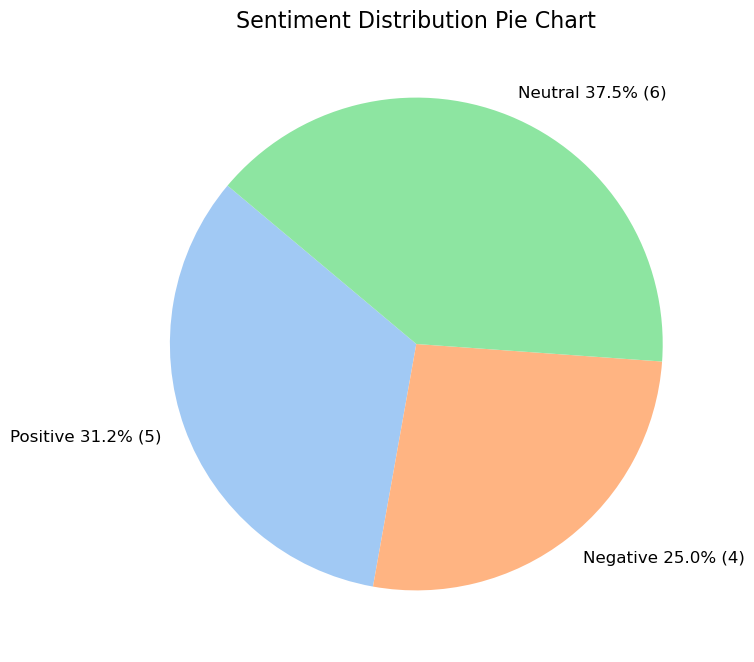

<Figure size 640x480 with 0 Axes>

In [605]:
# Thus, after manual checking the comments, the actual sentiment distribution is that: Positive 31.2%(5), Negative 25%(4), Neutral 37.5% (6).
#Then generate the corresponding visualization image, using seaborn and matplotlib.

# the parameter of the sentiment distribution
sentiment_counts = {
    "Positive": (31.2, 5),  
    "Negative": (25.0, 4),
    "Neutral": (37.5, 6)
}

# extract data and lable
labels = [f"{key} {value[0]}% ({value[1]})" for key, value in sentiment_counts.items()]
values = [value[0] for value in sentiment_counts.values()]

# set the colors
colors = sns.color_palette("pastel")[0:len(labels)]

#create pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    values, 
    labels=labels, 
    startangle=140, 
    colors=colors, 
    textprops={"fontsize": 12}  # 调整字体大小
)

# add title
plt.title("Sentiment Distribution Pie Chart", fontsize=16)

plt.show()

# save pie chart as png. image.
plt.savefig("sentiment_distribution_piechart.png", dpi=300)

In [535]:
all_tokens = []
for comment in filtered_comments["cleaned_comments"]:
    tokens = jieba.lcut(comment)
    all_tokens.extend(tokens)


token_counts = Counter(all_tokens)
print("high-fre：", token_counts.most_common(20))


high-fre： [(' ', 212), ('特朗普', 9), ('川普', 7), ('美国', 6), ('民主党', 3), ('哈里斯', 3), ('强敌', 3), ('继任者', 3), ('总统', 2), ('生活', 2), ('楼梯', 2), ('摔', 2), ('身亡', 2), ('伊万', 2), ('卡', 2), ('隐身', 2), ('背后', 2), ('对手', 2), ('懂王', 2), ('年', 2)]


In [537]:

stopwords = set(["", " ", "的", "是", "在", "和", "有", "说", "没", "那种","哈哈哈哈哈","哈哈哈"])  


filtered_token_counts = {word: count for word, count in token_counts.items() if word not in stopwords}

high_freq_words = sorted(filtered_token_counts.items(), key=lambda x: x[1], reverse=True)[:10]
print("high-frequency wordlist：", high_freq_words)
#The filtered high-frequency wordlist in english is that Donald Trump,9; Chuan Pu, the nickname of Trump, 7; America,6; Democratic Party,3; Harris 3; powerful enemy; Sucessor,3; President 2; life 2; stairs 2.


high-frequency wordlist： [('特朗普', 9), ('川普', 7), ('美国', 6), ('民主党', 3), ('哈里斯', 3), ('强敌', 3), ('继任者', 3), ('总统', 2), ('生活', 2), ('楼梯', 2)]


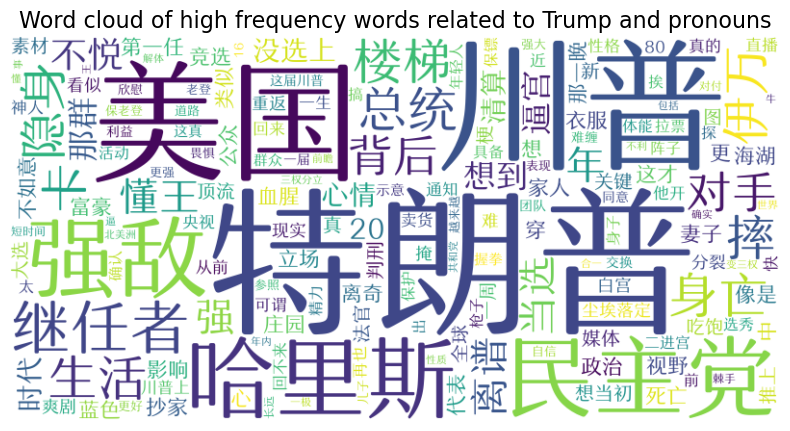

In [539]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# The wordcloud visualizes all the high-frequency words related to Trump.
wordcloud = WordCloud(
    font_path="/Users/cuiziyi/Desktop/Project_<AF43460>/汉仪润圆45W.ttf",  
    background_color="white",       
    width=800,                      
    height=400                      
).generate_from_frequencies(filtered_token_counts)


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  
plt.title("Word cloud of high frequency words related to Trump and pronouns", fontsize=16)
plt.show()
wordcloud.to_file("cooccurrence_wordcloud2.png")
